## The fermenter equation (cmol balance)

In CBI310 we’ll assume that all fermenters are well mixed and that no concentration or temperature gradients exist within the fermentation broth. In real life the assumption is often approximated where gradients are minimal. The easiest way to perform the mass balance over the fermenter is to consider the cmol balance of each component. We’ll start with a time-dependant model were the dynamic concentration and volume changes in the fermenter are incorporated by an accumulation term for each component ($\frac{dN_i}{dt}$). Note that the cmol quantity ($N_i$) is the product of the cmol concentration ($C_i$ in $\frac{cmol}{L}$) and the fermenter volume ($V$). The concentration of a component and/or volume will change with addition/removal of the component as well as formation/depletion of the component. The general cmol component balance is given by:

$$\frac{dN_i}{dt}=Q^F C^F_i-QC_i  + r_i C_X V $$  
-------------------
$$\left[\frac{cmol\,i}{h}\right]=
 \left[ \frac{cmol\,i}{L} \cdot \frac{L}{h} \right]
- \left[ \frac{cmol\,i}{L} \cdot \frac{L}{h} \right] + \left[ \frac{cmol\,i}{cmol\,X\cdot h} \cdot \frac{cmol\,X}{L} \cdot L \right] $$

** Check and understand the units of all the terms. All 4 terms should have the same units! **Note that the superscript $^F$ refers to a feed stream concentration ($C^F_i$) and the inlet volumetric flowrate ($Q^F$). Due to the perfect mixing the outlet concentration ($C_i$) will be the same as the concentration in the fermenter.

**Very important** to note the units and sign convention of $r_i$. In chapter 3 and 4 we used positive rates to determine stoichiometry. Accordingly all reagent rates were multiplies by $-1$ where positive  glucose and oxygen rates were presented by $-r_s$ and $-r_O$. The $r_i$ in the equation above represents production, so substrate or uptake rates will be negative according to the definition.

Apart from the cmol based rates ($r_i$) we'll define a volumetric rate ($r^V_i$) as follow:


$$r^V_i=r_i \cdot C_X $$
------------

$$\left[ \frac{cmol\,i}{L \cdot h} \right] = 
\left[ \frac{cmol\,i}{cmol\,X\cdot h} \cdot \frac{cmol\,X}{L} \right] $$
$$$$

Also note the relationship between cmol concentration ($C_i$) and the cmol amount ($C_i$). 

$$N_X=C_X\cdot V$$


Apart from the set of cmol balances, we also need a volume balance. When making the assumption that al liquids have the same density (feed and effluent) the following simple equation results:

$$\frac{dV}{dt}=Q^F-Q$$



### The batch fermenter

We'll start with batch fermentations, where the fermenter volume does not change since nothing is added or removed from the fermenter. Prove to yourself that the **fermenter equation** reduces to the following:

$$\frac{dC_i}{dt}=r_i C_X $$  
-------------------

The rates calculated in chapter 3 and 4 will be referred to as the **response function** or **rate function**. We are going to start by using a constant rate function. This implies that $\mu$ and $\theta$ will not change as the concentrations in the fermenter change. We'll use the example of anaerobic ethanol fermentation to take you through the steps of modelling a fermenter. To generate the response function we'll require the flux model:

<img src="etmap.png" width="570" />

We'll use the following physiological parameters:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu \qquad$|$\theta\qquad$
|----|-|-|-|-
|$\frac{\text{cmol $CO_2$}}{\text{cmol X}}$|$\frac{\text{mol ATP}}{\text{cmol X}}$|$\frac{1}{\text{h}}$|$\frac{\text{mol ATP}}{\text{cmol X}\cdot \text{h}}$
|0.12|1.8|0.3|0.1

The biomass formula is given by $CH_{1.8}O_{0.5}N_{0.2}$

We'll start by defining the parameters and importing the relevant Python functions:


In [35]:
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline
alpha, beta, gamma = 0.1, 0.1,1.8


We now want to define the _response function_ that **supplies the required rates to the fermentation equation**. In this example we will be working with  biomass, glucose, glycerol and ethanol rates ($r_X$,$r_S$,$r_G$ and $r_E$).

**Note that the response function is a function of fermenter concentrations where $C=[C_X,C_S,C_G,C_E]$**. We'll define $\mu$ and $\theta$ within the response function since these will be related to $C$ in chapter 6. You will also note that the response function is calculated with chapter 4 techniques:


In [36]:
def response_fun(C):
    
    mu, theta= 0.3, 0.1
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    K = numpy.matrix([0, 0, 0, theta, mu]).T
    r = numpy.linalg.solve(S, K) 
        
    
    return [mu,       # important to see the order of the rates (X,S,G,E)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[3,0],   # glycerol
            r[4,0]]   # ethanol   

The _fermenter equation_ will contain 4 separate equations:

|Biomass|Glucose|Glycerol|Ethanol
|-|-|-|-
|$\frac{dC_X}{dt}=r_X C_X $|$\frac{dC_S}{dt}=r_S C_X $|$\frac{dC_G}{dt}=r_G C_X $|$\frac{dC_E}{dt}=r_E C_X $  

The corresponding rates ($r_X$,$r_S$,$r_G$ and $r_E$) are 'fetched' from the response function.

The fermenter equation is given by:


In [37]:
def ferm_eq(C,t):
    Cx, Cs, Cg, Ce = C[0],C[1],C[2],C[3]  # order of components very important 
    r=response_fun([Cx, Cs, Cg, Ce])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,
            r[1]*Cx,    
            r[2]*Cx,
            r[3]*Cx]   

All that remains is to integrate and plot the _fermentation equation_. We will require the initial concentrations of the 4 components as well as a time span for the integration: 

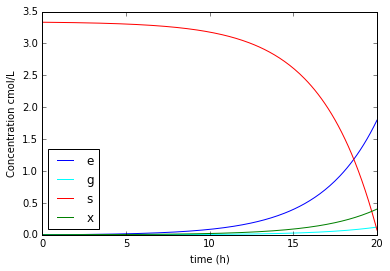

In [38]:
Co=[0.001, 100/30,0,0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=20                                    # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,200)           # define the timespan of the integration
C = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx=C[:,0]                                  
Cs=C[:,1]
Cg=C[:,2]
Ce=C[:,3]

plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cg, color='cyan', label='g')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()


So there you have it, your first fermenter profile. At his stage $\mu$ and $\theta$ are still constants. This implies that the  _response function_ returns the same rates as time progress. This will change in the next chapter.

Also note that the integration can easily run into negative numbers if the timespan of the integration is chosen too long. In real life growth or maintenance won't be possible without a positive substrate (glucose) concentration. The current math description is not fully realistic yet. We can induce the substrate requirement by redefining the response function:

In [39]:
def response_fun(C):
    
    if C[1]<=0:               #glucose concnetration
        mu, theta = 0,0
    else:
        mu, theta= 0.3, 0.1
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    K = numpy.matrix([0, 0, 0, theta, mu]).T
    r = numpy.linalg.solve(S, K) 
        
    
    return [mu,       # important to see the order of the rates (X,S,G,E)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[3,0],   # glycerol
            r[4,0]]   # ethanol   

If we re-integrate with a longer timespan using the newly defined response function above, we'll get the following:

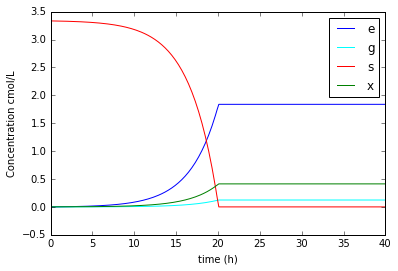

In [40]:
Co=[0.001, 100/30,0,0]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=40                                    # Integrate for 20 hours  
tspan=numpy.linspace(0,tmax,200)           # define the timespan of the integration
C = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx=C[:,0]                                  
Cs=C[:,1]
Cg=C[:,2]
Ce=C[:,3]

plt.plot(tspan, Ce, color='blue', label='e')
plt.plot(tspan, Cg, color='cyan', label='g')
plt.plot(tspan, Cs, color='red',label='s')
plt.plot(tspan, Cx, color='green',label='x')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Here you have the first interactive link between the bug and the fermenter environment! Remember the first 2 videos of the course. The bug altering the environment and the environment then altering the bug. This video aims to further explain the **LINK** which will be extensively used in the rest of CBI.

[Back to Contents page](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/List%20of%20contents.ipynb)